<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
import sys


sys.path.append("../FinRL-Library")

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
# from config.py start_date is a string
config.START_DATE = "2018-01-01"

In [5]:
# from config.py end_date is a string
config.END_DATE
print(f"start: {config.START_DATE}, end: {config.END_DATE}")

start: 2018-01-01, end: 2020-12-01


In [6]:
pprint(config.DOW_30_TICKER[:5])

['AAPL', 'MSFT', 'JPM', 'V', 'RTX']


In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER[:5]).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3670, 7)


In [8]:
df.shape

(3670, 7)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL
1,2018-01-02,107.629997,108.019997,106.809998,98.750923,13578800,JPM
2,2018-01-02,86.129997,86.309998,85.500000,82.383636,22483800,MSFT
3,2018-01-02,80.490875,81.107613,80.031464,74.994568,4918500,RTX
4,2018-01-02,114.570000,115.080002,113.949997,112.335358,6080900,V


In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)


processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
print(type(processed))

<class 'pandas.core.frame.DataFrame'>


In [12]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL,0.000000,0.0,66.666667,100.0,0.0
1,2018-01-02,107.629997,108.019997,106.809998,98.750923,13578800,JPM,0.000000,0.0,66.666667,100.0,0.0
2,2018-01-02,86.129997,86.309998,85.500000,82.383636,22483800,MSFT,0.000000,0.0,66.666667,100.0,0.0
3,2018-01-02,80.490875,81.107613,80.031464,74.994568,4918500,RTX,0.000000,0.0,66.666667,100.0,0.0
4,2018-01-02,114.570000,115.080002,113.949997,112.335358,6080900,V,0.000000,0.0,66.666667,100.0,0.0
5,2018-01-03,43.132500,43.637501,42.990002,41.434864,118071600,AAPL,-0.000162,0.0,66.666667,100.0,0.0
6,2018-01-03,107.860001,108.489998,107.480003,98.851555,11901000,JPM,0.002258,100.0,66.666667,100.0,0.0
7,2018-01-03,86.059998,86.510002,85.970001,82.767044,26061400,MSFT,0.008602,100.0,66.666667,100.0,0.0
8,2018-01-03,81.491501,81.938324,81.384521,76.094666,7958900,RTX,0.024682,100.0,66.666667,100.0,0.0
9,2018-01-03,114.949997,115.790001,114.660004,113.453690,6946100,V,0.025091,100.0,66.666667,100.0,0.0


In [13]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2020-12-01')
print(len(train))
print(len(trade))


1255
2415


In [14]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,107.629997,108.019997,106.809998,98.750923,13578800,JPM,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,86.129997,86.309998,85.500000,82.383636,22483800,MSFT,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,80.490875,81.107613,80.031464,74.994568,4918500,RTX,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,114.570000,115.080002,113.949997,112.335358,6080900,V,0.0,0.0,66.666667,100.0,0.0


In [15]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.562561,148158800,AAPL,-2.019903,37.865996,-91.567852,42.250809,0.0
0,2019-01-02,95.949997,99.779999,95.940002,92.928543,15670900,JPM,-2.599788,43.026559,-61.120190,16.147419,0.0
0,2019-01-02,99.550003,101.750000,98.940002,98.602066,35329300,MSFT,-1.908755,45.768318,-81.402190,21.611852,0.0
0,2019-01-02,66.179985,68.187538,65.601006,64.796608,9361700,RTX,-2.988610,36.797678,-109.397938,44.007807,0.0
0,2019-01-02,130.000000,133.740005,129.600006,131.264542,8788000,V,-2.114526,47.277723,-46.722946,11.039625,0.0


In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 31


In [17]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                        state_space = state_space,
                        hmax = 100,
                        initial_amount = 1000000,
                        transaction_cost_pct = 0.001)


env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)


env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade) 

In [18]:
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [19]:
type(config)
config.__dict__['DDPG_PARAMS']


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}

In [20]:
da = DRLAgent(env = env_train)


model = da.get_model("ppo")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU1 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [21]:
trained = da.train_model(model, 'ppo')

Logging to tensorboard_log/ppo/ppo_2
begin_total_asset:1000000
end_total_asset:980783.2619222986
total_reward:-19216.73807770142
total_cost:  5710.635942344017
total_trades:  1159
Sharpe:  -0.47552546448319843
begin_total_asset:1000000
end_total_asset:981331.0780076551
total_reward:-18668.921992344898
total_cost:  6233.00296469264
total_trades:  1192
Sharpe:  -0.39489663525664703
begin_total_asset:1000000
end_total_asset:966591.9161499362
total_reward:-33408.08385006385
total_cost:  6369.023943100556
total_trades:  1207
Sharpe:  -0.5574360800762165
begin_total_asset:1000000
end_total_asset:987149.732487096
total_reward:-12850.267512904014
total_cost:  6679.30776307029
total_trades:  1234
Sharpe:  -0.18716276188846684
begin_total_asset:1000000
end_total_asset:950495.3942091037
total_reward:-49504.60579089634
total_cost:  6944.083519609585
total_trades:  1213
Sharpe:  -0.5846514961109903
begin_total_asset:1000000
end_total_asset:950876.7612745927
total_reward:-49123.23872540728
total_cos

KeyboardInterrupt: 

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [20]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0002,
			  'verbose':0,
			  'timesteps':150000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU1 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


begin_total_asset:1000000
end_total_asset:5784807.489077928
total_reward:4784807.489077928
total_cost:  171261.18329014312
total_trades:  66681
Sharpe:  1.158384297778545
begin_total_asset:1000000
end_total_asset:6129139.166672241
total_reward:5129139.166672241
total_cost:  171407.4013669429
total_trades:  66727
Sharpe:  1.1511288534069641
begin_total_asset:1000000
end_total_asset:3884702.706202592
total_reward:2884702.706202592
total_cost:  184465.7187718543
total_trades:  67589
Sharpe:  0.9857818017305219
begin_total_asset:1000000
end_total_asset:6400715.897313735
total_reward:5400715.897313735
total_cost:  172584.2798994141
total_trades:  66016
Sharpe:  1.1758434603625492
begin_total_asset:1000000
end_total_asset:5002705.819736808
total_reward:4002705.8197368076
total_cost:  200837.72079600804
total_trades:  67515
Sharpe:  1.0793254257378413
begin_total_asset:1000000
end_total_asset:3988230.9030086207
total_reward:2988230.9030086207
total_cost:  215942.0191006974
total_trades:  6883

KeyboardInterrupt: 

### Model 2: DDPG

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
                     'learning_rate':0.001,
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

### Model 3: PPO

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'batch_size': 64,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':50000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========


begin_total_asset:1000000
end_total_asset:3048741.3939381745
total_reward:2048741.3939381745
total_cost:  245568.3302282693
total_trades:  72462
Sharpe:  0.9202481544831457
begin_total_asset:1000000
end_total_asset:3293240.652184626
total_reward:2293240.652184626
total_cost:  208401.75301929898
total_trades:  69573
Sharpe:  0.9548892552085766
begin_total_asset:1000000
end_total_asset:3770063.9598072213
total_reward:2770063.9598072213
total_cost:  163858.87472231584
total_trades:  66022
Sharpe:  1.0100154114628663
begin_total_asset:1000000
end_total_asset:3533338.6618839577
total_reward:2533338.6618839577
total_cost:  140710.91081377305
total_trades:  63468
Sharpe:  0.8658687183317452
begin_total_asset:1000000
end_total_asset:3624214.190819685
total_reward:2624214.190819685
total_cost:  154313.0847744043
total_trades:  65276
Sharpe:  0.8993471111207018
begin_total_asset:1000000
end_total_asset:3202571.663253775
total_reward:2202571.663253775
tot

### Model 4: TD3

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':200000, 
                     'learning_rate': 0.0002,
			               'verbose':0,
			               'timesteps':50000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:2662114.6849694927
total_reward:1662114.6849694927
total_cost:  5154.707305372425
total_trades:  35274
Sharpe:  0.6952087010828358
begin_total_asset:1000000
end_total_asset:2988142.5784285073
total_reward:1988142.5784285073
total_cost:  1632.59511942303
total_trades:  40163
Sharpe:  0.7289450168804903
begin_total_asset:1000000
end_total_asset:2883484.519447818
total_reward:1883484.519447818
total_cost:  1214.8873761913726
total_trades:  37755
Sharpe:  0.7095756761323406
begin_total_asset:1000000
end_total_asset:2873489.4430507906
total_reward:1873489.4430507906
total_cost:  1209.6024044447397
total_trades:  37753
Sharpe:  0.7123425504445975
begin_total_asset:1000000
end_total_asset:2915279.9369537304
total_reward:1915279.9369537304
total_cost:  1228.91289347425
total_trades:  37752
Sharpe:  0.7163200645078105
begin_total_asset:1000000
end_total_asset:2895154.510926656
total_reward:1895154.510926656
total_

### Model 5: SAC

In [21]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)
agent = DRLAgent(env = env_train)
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
sac_params_tuning={
  'batch_size': 128,
 'buffer_size': 100000,
  'ent_coef':'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts':200,
 'timesteps': 40000,
 'verbose': 0}
model_sac = agent.train_SAC(model_name = "SAC_{}".format(now), model_params = sac_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:4382164.2840514295
total_reward:3382164.2840514295
total_cost:  14512.69043110383
total_trades:  36334
Sharpe:  1.1494700817635037
begin_total_asset:1000000
end_total_asset:4955607.994816036
total_reward:3955607.994816036
total_cost:  17928.61809677992
total_trades:  45029
Sharpe:  1.085855072403009
begin_total_asset:1000000
end_total_asset:3971617.1898101172
total_reward:2971617.1898101172
total_cost:  71424.43677836886
total_trades:  47655
Sharpe:  0.8644388344629765
begin_total_asset:1000000
end_total_asset:4063646.421059399
total_reward:3063646.421059399
total_cost:  95564.13759816512
total_trades:  51492
Sharpe:  0.9319558499321027
begin_total_asset:1000000
end_total_asset:6149432.4896843005
total_reward:5149432.4896843005
total_cost:  159127.89068911012
total_trades:  60027
Sharpe:  1.12755778213282
begin_total_asset:1000000
end_total_asset:4544545.271438425
total_reward:3544545.2714384254
total_cos

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [22]:
data_turbulence = df[(df.date<'2019-01-01') & (df.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [23]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.936148
std        38.178007
min         0.000000
25%        58.034373
50%        74.015123
75%        96.948808
max       230.256623
Name: turbulence, dtype: float64

In [24]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [25]:
turbulence_threshold

230.25662291179367

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [26]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade,
                                         turbulence_threshold=250) 

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_sac,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

previous_total_asset:1000000
end_total_asset:1288628.9585634898
total_reward:288628.95856348984
total_cost:  8675.27399769877
total trades:  7938
Sharpe:  0.6596489834598107


In [27]:
df_account_value.shape

(483, 2)

In [28]:
df_account_value.head()

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-03,9.974314e+05
2,2019-01-04,1.004176e+06
3,2019-01-07,1.005076e+06
4,2019-01-08,1.011279e+06


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [29]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  17.75767501128078
sharpe ratio:  0.6596489834598107
Annual return          0.141453
Cumulative returns     0.288629
Annual volatility      0.247877
Sharpe ratio           0.659649
Calmar ratio           0.470167
Stability              0.002006
Max drawdown          -0.300857
Omega ratio            1.135149
Sortino ratio          0.924965
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.967231
Daily value at risk   -0.030581
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  17.75767501128078
sharpe ratio:  0.6596489834598107
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)


Start date,2019-01-03
End date,2020-11-30
Total months,22
,Backtest
Annual return,14.177%
Cumulative returns,28.863%
Annual volatility,24.788%
Sharpe ratio,0.66
Calmar ratio,0.47
Stability,0.00
Max drawdown,-30.086%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.09,2020-02-12,2020-04-03,2020-11-09,194
1,8.80,2019-03-01,2019-06-03,2019-07-12,96
2,8.56,2019-07-23,2019-08-14,2019-09-11,37
3,5.18,2019-09-18,2019-10-21,2019-11-11,39
4,3.77,2020-01-16,2020-01-27,2020-02-06,16


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


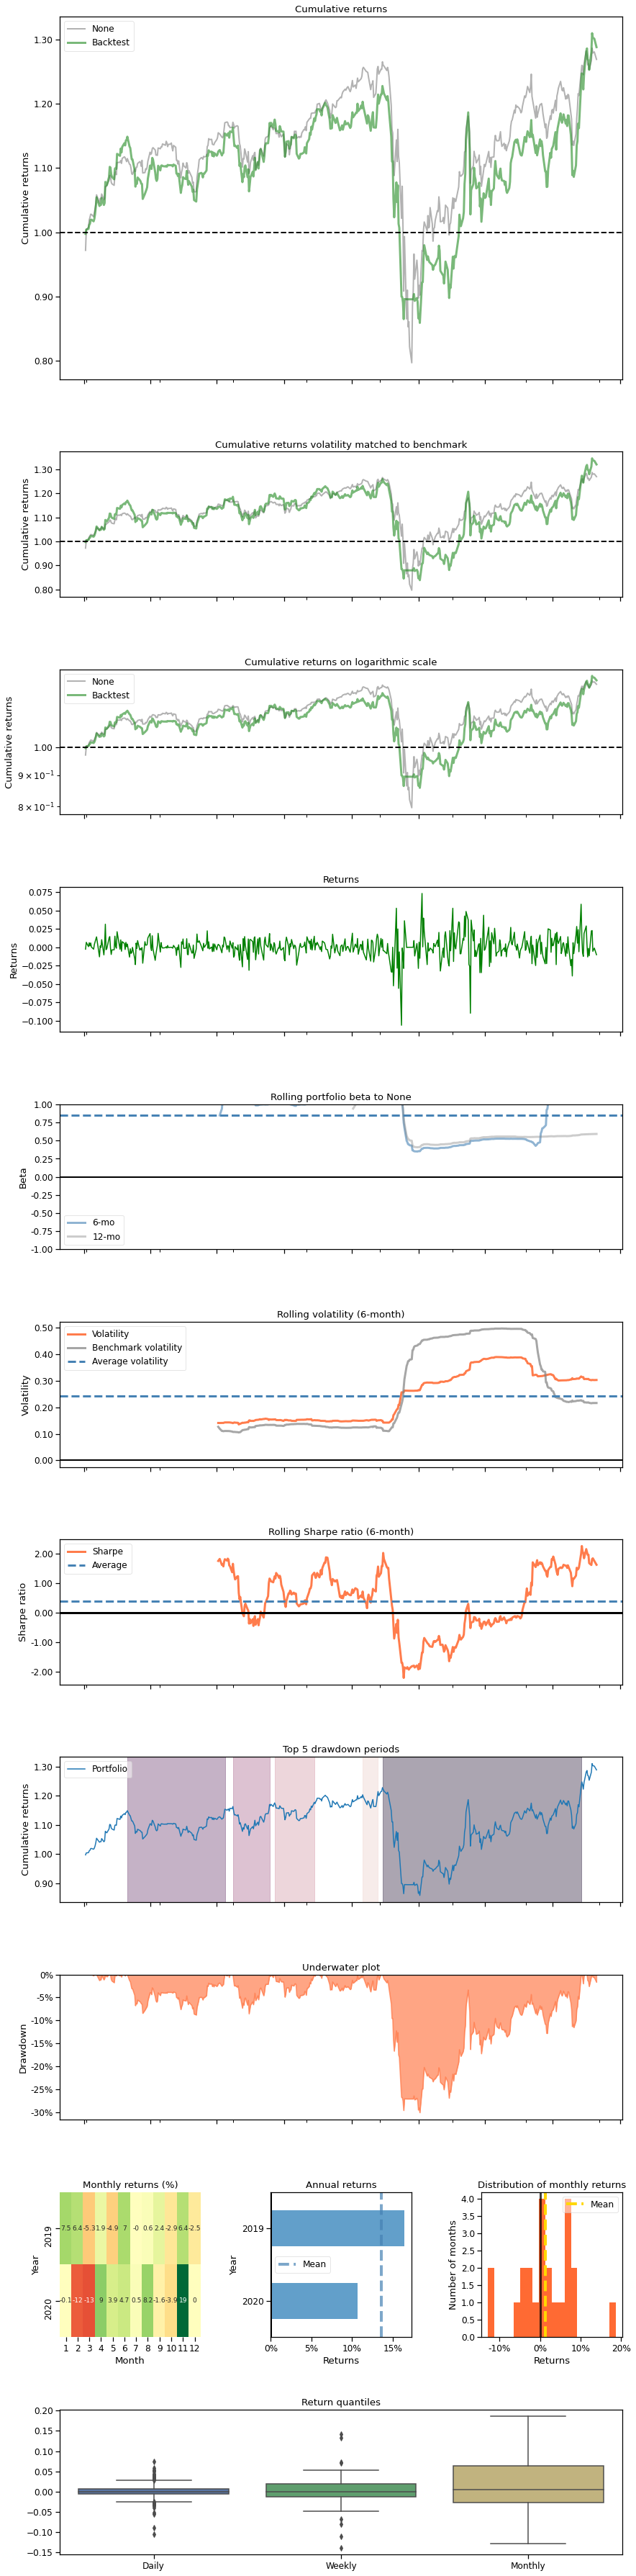

In [30]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-12-01')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [31]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-12-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.132593
Cumulative returns     0.269525
Annual volatility      0.280347
Sharpe ratio           0.586312
Calmar ratio           0.357526
Stability              0.060828
Max drawdown          -0.370862
Omega ratio            1.137261
Sortino ratio          0.807330
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844803
Daily value at risk   -0.034668
Alpha                  0.000000
Beta                   1.000000
dtype: float64
